## 過学習
過学習とは訓練データ数に対してパラメータの自由度が高すぎることなどが原因して訓練データに対しては高い精度で適合するが未知のデータに対しての適合度合いが低くなってしまうことを指します。<br>
例としてに対して真の分布$y=sin(x)$に平均0分散0.4のガウス分布に従うノイズを加えたものを学習してみる<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

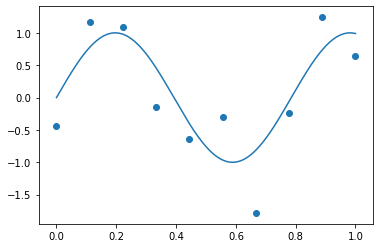

(10, 8)
(10000, 8)


In [2]:
np.random.seed(123)
N = 10
#N = 10000
#２度目はこちらを外して再実行してみてください
batch_size = N//10
L = 1
noise = \
np.random.normal(
    loc   = 0,      # 平均
    scale = 0.4,      # 標準偏差
    size  = N,# 出力配列のサイズ
)
XX = np.linspace(0, L, 10000)
Y = np.sin(8*XX)
xx = np.linspace(0, L, N)
y = np.sin(8*xx) + noise
plt.scatter(xx, y)
plt.plot(XX, Y)
plt.show()
def dim_8(x):
    return [x**0, x**1, x**2, x**3, x**4, x**5, x**6, x**7]

x = []
for i in range(len(xx)):
    x.append(dim_8(xx[i]))
x = np.array(x)
print(x.shape)

X = []
for i in range(len(XX)):
    X.append(dim_8(XX[i]))
X = np.array(X)
print(X.shape)

y = y.reshape(N, 1)

プロットされた11個のデータを学習し、$y=sin(x)$を近似することが目標となる。7次式で近似することにしてとりあえずpytorchで！

In [3]:
import torch
import torch.nn as nn
import torch.optim as optimizers
from sklearn.utils import shuffle

In [4]:
torch.manual_seed(123)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, output_dim)
        self.layers = [self.l1]
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x

In [6]:
model = MLP(8, 1).to(device)

In [7]:
criterion = nn.L1Loss()
optimizer = optimizers.SGD(model.parameters(), lr=1)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    model.train()                              #学習モードへ移行 model.eval()で評価モード
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()              #勾配初期化
    loss.backward()                         #勾配計算
    optimizer.step()                         #パラメータ更新
    return loss

各パラメータの概形と初期値をチェック！

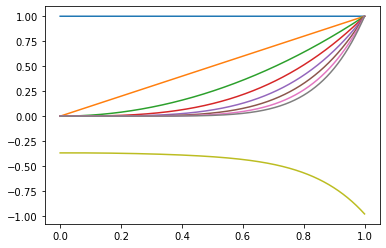

In [8]:
X_ = torch.Tensor(X).to(device)
for i in range(8):
    plt.plot(XX, XX**i)
plt.plot(XX, model(X_).to(torch.float).cpu().detach().numpy())

In [9]:
epochs = 100
n_batches = x.shape[0] // batch_size
for epoch in range(epochs):
    train_loss = 0.
    x_, y_ = shuffle(x, y)
    x_ = torch.Tensor(x_).to(device)
    y_ = torch.Tensor(y_).to(device)
    for n_batches in range(n_batches):
        start = n_batches * batch_size
        end = start + batch_size
        loss = train_step(x_[start:end], y_[start:end])
        train_loss += loss.item()
    
    print('epoch:{}, loss:{:.10}'.format(epoch+1, train_loss))

epoch:1, loss:18.57682922
epoch:2, loss:18.99835798
epoch:3, loss:14.558523
epoch:4, loss:14.51427555
epoch:5, loss:10.81308487
epoch:6, loss:14.95002317
epoch:7, loss:9.794056773
epoch:8, loss:7.736248374
epoch:9, loss:3.4720788
epoch:10, loss:0.5453408957
epoch:11, loss:0.0
epoch:12, loss:0.0
epoch:13, loss:0.0
epoch:14, loss:0.0
epoch:15, loss:0.0
epoch:16, loss:0.0
epoch:17, loss:0.0
epoch:18, loss:0.0
epoch:19, loss:0.0
epoch:20, loss:0.0
epoch:21, loss:0.0
epoch:22, loss:0.0
epoch:23, loss:0.0
epoch:24, loss:0.0
epoch:25, loss:0.0
epoch:26, loss:0.0
epoch:27, loss:0.0
epoch:28, loss:0.0
epoch:29, loss:0.0
epoch:30, loss:0.0
epoch:31, loss:0.0
epoch:32, loss:0.0
epoch:33, loss:0.0
epoch:34, loss:0.0
epoch:35, loss:0.0
epoch:36, loss:0.0
epoch:37, loss:0.0
epoch:38, loss:0.0
epoch:39, loss:0.0
epoch:40, loss:0.0
epoch:41, loss:0.0
epoch:42, loss:0.0
epoch:43, loss:0.0
epoch:44, loss:0.0
epoch:45, loss:0.0
epoch:46, loss:0.0
epoch:47, loss:0.0
epoch:48, loss:0.0
epoch:49, loss:0.0
e

<class 'torch.Tensor'>


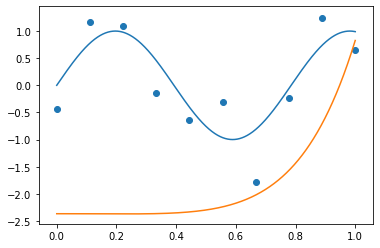

In [10]:
model.eval()
plt.plot(XX, Y)
X_ = torch.Tensor(X).to(device)
print(type(model(X_)))
plt.scatter(xx, y[:,0])
plt.plot(XX, model(X_).to(torch.float).cpu().detach().numpy())
plt.show()

# は？
全然オーバーフィッティングしないじゃん。なんなら表現すらできてないじゃん.とガチで3時間悩んだ結果、共分散が高すぎることが原因では？と思い至る

In [11]:
import seaborn as sns
import scipy as sc

In [12]:
z = sc.stats.zscore(x)
cov = np.cov(z.T)
print(cov.shape)

(8, 8)


/mnt/nfs/kawanan/anaconda3/envs/pytorch_advanced/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


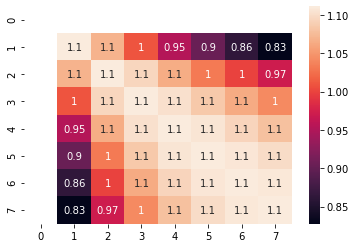

In [13]:
sns.heatmap(cov, annot=True)
display()

##  あぁ。。。やっぱり。。。
そうですよねー。xを0から1までの範囲で動かしてるから相関がめちゃくちゃあるんですよねぇ。。。パラメータ間に高い相関があると学習がうまく進まないですよねぇ。<br>
（というかデータをsc.stats.zscore(x)で標準化してるはずなのに相関係数1.1って何事？）<br><br>
# パラメータ間になんで強い相関があると学習が進まないのか？
その前に一度ディープラーニングから離れて最小二乗法で近似してオーバーフィッティングさせてみようと思います。データ数10に対してパラメータが0から7までの8次元だから、ムーアペンローズの擬似逆行列作って

[-4.45999514e-01  2.56529172e+01 -6.59360939e+01 -4.90171553e+02
  2.73483557e+03 -5.39068679e+03  4.77909168e+03 -1.59171425e+03]


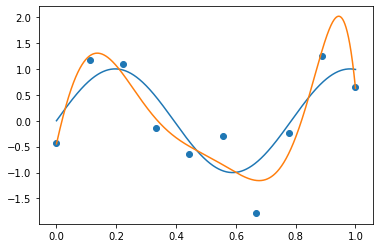

In [14]:
w = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)), x.T), y[:,0])
print(w)
plt.scatter(xx, y[:,0])
plt.plot(XX, Y)
plt.plot(XX, np.dot(X, w))

お手本のようなオーバーフィッティングですがここで重みベクトル$\bf w$の数値を確認してみましょう。随分とプラスにマイナスにばらつきがあるように見えますね。しかしながら先ほどの手法で使用した確率的勾配降下法ではこのばらつきにたどり着くことができません。理由としては**ほぼ同じ方向に学習してしまうから**です。全く同じ数値をとるパラメータがあるとすると、それらに対する重みベクトルの更新量は同じですよね。なので今回の例だとほぼ全てのパラメータに対する重みの学習が足並みを揃えてプラスならプラス、マイナスならマイナスというふうに進んだのだと思われます。これでは求めたかった重みにたどり着くことができません。ていうか相関係数0.8以上を強い相関とするならこれほぼ１次式で近似してるのと変わらないですねぇ。<br><br>
# つまり基底関数の選び方が悪かった
今回は基底関数に（0から1の間で)相関の強い多項式を持ってきてしまったことが学習ができなかった原因でしょう。ということで次は確立的勾配降下法に合うような基底関数を持ってきて学習してみましょう。これでうまくいってくれー。
### ガウス関数
てことで次は基底関数にガウス関数を持ってきます。

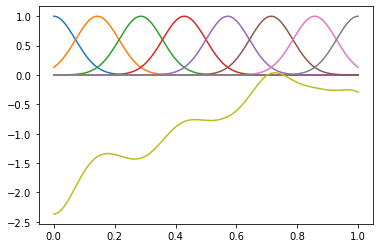

In [15]:
def gauss(x):
    return [np.exp(-((x-(i/7))**2)/0.01) for i in range(8)]
x = np.array([gauss(i) for i in xx])
X = np.array([gauss(i) for i in XX])
for i in range(8):
    plt.plot(XX, np.exp(-((XX-(i/7))**2)/0.01))
X_ = torch.Tensor(X).to(device)
plt.plot(XX, model(X_).to(torch.float).cpu().detach().numpy())

このガウス基底関数の共分散が本当に低いかチェック！

In [16]:
z = sc.stats.zscore(x)
cov = np.cov(z.T)
print(cov.shape)

(8, 8)


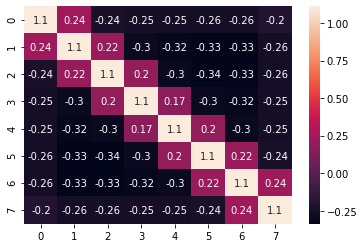

In [17]:
sns.heatmap(cov, annot=True)
display()

先ほどよりも相関が弱そう！ということで

In [18]:
epochs = 100
n_batches = x.shape[0] // batch_size
for epoch in range(epochs):
    train_loss = 0.
    x_, y_ = shuffle(x, y)
    x_ = torch.Tensor(x_).to(device)
    y_ = torch.Tensor(y_).to(device)
    for n_batches in range(n_batches):
        start = n_batches * batch_size
        end = start + batch_size
        loss = train_step(x_[start:end], y_[start:end])
        train_loss += loss.item()
    
    print('epoch:{}, loss:{:.10}'.format(epoch+1, train_loss))

epoch:1, loss:13.86797987
epoch:2, loss:6.342430085
epoch:3, loss:11.00819656
epoch:4, loss:4.727591693
epoch:5, loss:6.189769655
epoch:6, loss:5.510507941
epoch:7, loss:5.217170477
epoch:8, loss:2.760744631
epoch:9, loss:1.00064069
epoch:10, loss:0.2044674158
epoch:11, loss:0.0
epoch:12, loss:0.0
epoch:13, loss:0.0
epoch:14, loss:0.0
epoch:15, loss:0.0
epoch:16, loss:0.0
epoch:17, loss:0.0
epoch:18, loss:0.0
epoch:19, loss:0.0
epoch:20, loss:0.0
epoch:21, loss:0.0
epoch:22, loss:0.0
epoch:23, loss:0.0
epoch:24, loss:0.0
epoch:25, loss:0.0
epoch:26, loss:0.0
epoch:27, loss:0.0
epoch:28, loss:0.0
epoch:29, loss:0.0
epoch:30, loss:0.0
epoch:31, loss:0.0
epoch:32, loss:0.0
epoch:33, loss:0.0
epoch:34, loss:0.0
epoch:35, loss:0.0
epoch:36, loss:0.0
epoch:37, loss:0.0
epoch:38, loss:0.0
epoch:39, loss:0.0
epoch:40, loss:0.0
epoch:41, loss:0.0
epoch:42, loss:0.0
epoch:43, loss:0.0
epoch:44, loss:0.0
epoch:45, loss:0.0
epoch:46, loss:0.0
epoch:47, loss:0.0
epoch:48, loss:0.0
epoch:49, loss:0.

<class 'torch.Tensor'>


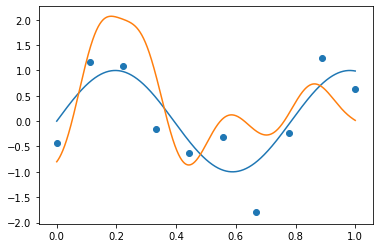

In [19]:
model.eval()
plt.plot(XX, Y)
X_ = torch.Tensor(X).to(device)
print(type(model(X_)))
plt.plot(XX, model(X_).to(torch.float).cpu().detach().numpy())
plt.scatter(xx, y[:,0])
plt.show()

# やったぜ
見事にオーバーフィッティングしてくれました（？）ということでみなさんディープラーニングを行う際にはパラメータの相関に気をつけて、相関の高いパラメータ同士は事前にどちらかを削除するか違う軸を持って来るようにしましょう.
# 本題に帰ろう
本題に帰りましょう。このような問題に対してどのような手法があるのか
### 1.データ数を増やす
そもそもがパラメータ数に対してデータが少なすぎることが原因ですのでデータを大量に持ってくれば良いのです。実際に上記のプログラムのサンプル数を10000にしてもう一度学習させてみましょう。先ほどよりも良い結果が得られるはずです。
### 2.1 初期値を色々と変えて平均を取ろう（アンサンブル学習）
(ガウス関数フィッティングにおいて)過学習したモデルは学習データ点に対して高い精度を誇りますが、学習データ間に存在する未知の点に対して精度が低くなります。そこで重みの初期値を色々変えて学習させたモデルをいくつか持ってきて未知のデータに対する予測をそれぞれ吐き出させ、平均をとることである程度精度をあげようというもの。事後分布の平均解をとることに似てる。
### 2.2 一つのモデルで色々な学習をしよう（ドロップアウト）
多層ニューラルネットを用いたモデルでは効率的に（擬似的に）モデルをいくつか作成し、平均をとる方法が存在します。それがドロップアウト層の導入です。<br>
これは学習時にランダムにいくつかのニューロンを不活性にしておくことで実現します。こうすることで様々なニューロンの組み合わせで学習することができます。学習が終わり評価をする際には全てのニューロンを活性化させます。様々なモデルを持ってきて平均をとることを擬似的に達成することができますが、その分学習に多くの回数を費やす必要があるのでepoch数を増やすようにしましょう。
```python
#Keras
model = Sequential()
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))#引数には不活性にするニューロンの割合を与えます
...
#TensorFlow
super().__init__()
self.l1 = Dense(hidden_dim, activation='relu')
delf.d1 = Dropout(0.5)
...
#Pytorch
super().__init__()
self.l1 = nn.Linear(input_dim, hidden_dim)
self.a1 = nn.ReLU()
self.d1 = nn.Dropout(0.5)
...
```

追記
#### 今回は損失関数に絶対値誤差(L1Loss)を使ったけど最小二乗誤差(MSELoss)を使用するとバグるのは何故？